In [2]:

# This Python 3 environment comes with many helpful analytics libraries installed

# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the 
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from google.colab import drive
drive.mount('/content/gdrive')


# Plotting Libs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# magic function
%matplotlib inline

import collections

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Read the data from Tags
df_tags = pd.read_csv('/content/gdrive/My Drive/Tags.csv', encoding='iso-8859-1')

In [0]:
# for plot top10 tags

def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(9,8))
    plt.ylabel("Number of question associations")
    
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009)]


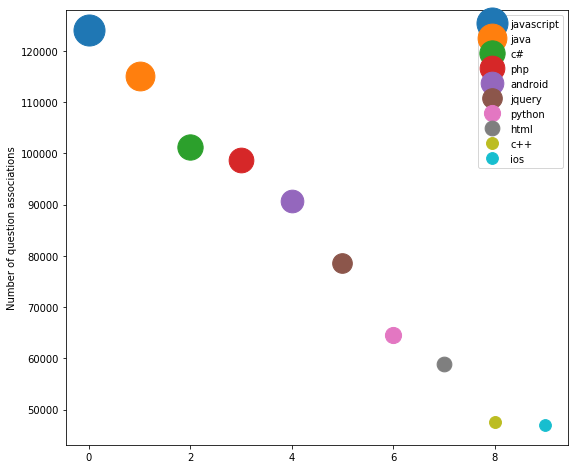

In [5]:
tagCount =  collections.Counter(list(df_tags['Tag'])).most_common(10)

print(tagCount)
plot_tags(tagCount)

In [0]:
top10=['javascript','java','c#','php','android','jquery','python','html','c++','ios']

In [7]:
tag_top10= df_tags[df_tags.Tag.isin(top10)]

print (tag_top10.shape)
tag_top10.head()

(826739, 2)


,Id,Tag
14,260,c#
18,330,c++
28,650,c#
35,930,c#
39,1010,c#


In [0]:
def add_tags(question_id):
    return tag_top10[tag_top10['Id'] == question_id['Id']].Tag.values

top10 = tag_top10.apply(add_tags, axis=1)

In [9]:
len(top10),tag_top10.shape

(826739, (826739, 2))

In [10]:
tag_top10=pd.concat([tag_top10, top10.rename('Tags')], axis=1)
tag_top10.head()

,Id,Tag,Tags
14,260,c#,[c#]
18,330,c++,[c++]
28,650,c#,[c#]
35,930,c#,[c#]
39,1010,c#,[c#]


In [11]:
tag_top10.drop(["Tag"], axis=1, inplace=True)
tag_top10.shape

(826739, 2)

In [0]:
top10_tags=tag_top10.loc[tag_top10.astype(str).drop_duplicates().index]

In [13]:
ques = pd.read_csv('/content/gdrive/My Drive/question_clean.csv', encoding='iso-8859-1')
ques.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,This is something I've pseudo-solved many time...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...


In [14]:
total=pd.merge(ques, top10_tags, on='Id')
print(total.shape)
total.head()

(706336, 8)


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tags
0,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,[c#]
1,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,I am working on a collection of classes used f...,[c++]
2,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,I would like the version property of my applic...,[c#]
3,930,245.0,2008-08-04T00:47:25Z,NaN,28,How do I connect to a database and loop over a...,What's the simplest way to connect and query a...,[c#]
4,1010,67.0,2008-08-04T03:59:42Z,NaN,14,"How to get the value of built, encoded ViewState?",I need to grab the base64-encoded representati...,[c#]


In [0]:
#Natural language processing using keras

In [16]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence


from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, GRU ,concatenate
from keras.models import Model

Using TensorFlow backend.


In [17]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(total.Tags)
labels = multilabel_binarizer.classes_
labels

array(['android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript',
       'jquery', 'php', 'python'], dtype=object)

In [0]:
train,test=train_test_split(total[:706336],test_size=0.20,random_state=24)

In [19]:
train.shape,test.shape

((565068, 8), (141268, 8))

In [0]:
X_train_t=train['Title']
X_train_b=train['Body']
y_train=multilabel_binarizer.transform(train['Tags'])

X_test_t=test['Title']
X_test_b=test['Body']
y_test=multilabel_binarizer.transform(test['Tags'])

In [21]:
 import nltk
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
#Train the model for Title tag

sent_lens_t=[]
for sent in train['Title']:
    sent_lens_t.append(len(word_tokenize(sent)))
max(sent_lens_t)

59

In [23]:
np.quantile(sent_lens_t,0.97)

18.0

In [0]:
max_len_t = 18
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_t)
sequences_train_t = tok.texts_to_sequences(X_train_t)

In [25]:
# Find vocabulary length of title
vocab_len_t=len(tok.index_word.keys())
vocab_len_t

85725

In [26]:
sequences_matrix_train_t = sequence.pad_sequences(sequences_train_t,maxlen=max_len_t)
sequences_matrix_train_t

array([[    0,     0,     0, ...,     9,    89,    33],
       [    0,     0,     0, ...,   434,    11,  1631],
       [    0,     0,     0, ...,   175,   211,  1213],
       ...,
       [    0,     0,     0, ...,    10,    74,  2816],
       [    0,     0,     0, ...,     2,    18,    81],
       [    0,     0,     0, ..., 15470,   789,   249]], dtype=int32)

In [0]:
sequences_test_t = tok.texts_to_sequences(X_test_t)
sequences_matrix_test_t = sequence.pad_sequences(sequences_test_t,maxlen=max_len_t)

In [28]:
sequences_matrix_train_t.shape,  sequences_matrix_test_t.shape,  y_train.shape,  y_test.shape

((565068, 18), (141268, 18), (565068, 10), (141268, 10))

In [29]:
#Train the model for Body tag

sent_lens_b=[]
for sent in train['Body']:
    sent_lens_b.append(len(word_tokenize(sent)))
max(sent_lens_b)

14682

In [30]:
np.quantile(sent_lens_b,0.90)

599.0

In [0]:
max_len_b = 599
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_b)
sequences_train_b = tok.texts_to_sequences(X_train_b)

In [32]:
#Find vocabulary length of body tag

vocab_len_b =len(tok.index_word.keys())
vocab_len_b 

1738012

In [33]:
sequences_matrix_train_b = sequence.pad_sequences(sequences_train_b,maxlen=max_len_b)
sequences_matrix_train_b

array([[   0,    0,    0, ...,   17,  231,  240],
       [   0,    0,    0, ...,  276,  746,  686],
       [   0,    0,    0, ...,    6,  670, 4620],
       ...,
       [   0,    0,    0, ...,   24,   70,  738],
       [   0,    0,    0, ...,  202,   62,   10],
       [   0,    0,    0, ...,  182,  201,   10]], dtype=int32)

In [0]:
sequences_test_b = tok.texts_to_sequences(X_test_b)
sequences_matrix_test_b = sequence.pad_sequences(sequences_test_b,maxlen=max_len_b)

In [35]:
sequences_matrix_train_t.shape,  sequences_matrix_train_b.shape,  y_train.shape

((565068, 18), (565068, 599), (565068, 10))

In [36]:
sequences_matrix_test_t.shape,  sequences_matrix_test_b.shape,  y_test.shape

((141268, 18), (141268, 599), (141268, 10))

In [0]:
def RNN():
    # Title Only
    title_input = Input(name='title_input',shape=[max_len_t])
    title_Embed = Embedding(vocab_len_t+1,2000,input_length=max_len_t,mask_zero=True,name='title_Embed')(title_input)
    gru_out_t = GRU(300)(title_Embed)
    
    # auxiliary output to tune GRU weights smoothly 
    auxiliary_output = Dense(10, activation='softmax', name='aux_output')(gru_out_t)   
    
    # Body Only
    body_input = Input(name='body_input',shape=[max_len_b]) 
    body_Embed = Embedding(vocab_len_b+1,8000,input_length=max_len_b,mask_zero=True,name='body_Embed')(body_input)
    gru_out_b = GRU(200)(body_Embed)
    
    # combined with GRU output
    com = concatenate([gru_out_t, gru_out_b])
    
    # now the combined data is being fed to dense layers
    dense1 = Dense(400,activation='relu')(com)
    dp1 = Dropout(0.5)(dense1)
    bn = BatchNormalization()(dp1) 
    dense2 = Dense(150,activation='relu')(bn)
    
    main_output = Dense(10, activation='softmax', name='main_output')(dense2)
    
    model = Model(inputs=[title_input, body_input],outputs=[main_output, auxiliary_output])
    return model

In [38]:
model = RNN()
model.summary()

W0816 15:50:17.621904 140710096906112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 15:50:17.688896 140710096906112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 15:50:17.716113 140710096906112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 15:50:18.144909 140710096906112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruct

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 18)           0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         (None, 599)          0                                            
__________________________________________________________________________________________________
title_Embed (Embedding)         (None, 18, 2000)     171452000   title_input[0][0]                
__________________________________________________________________________________________________
body_Embed (Embedding)          (None, 599, 8000)    13904104000 body_input[0][0]                 
__________________________________________________________________________________________________
gru_1 (GRU

In [39]:
model.compile(optimizer='adam',loss={'main_output': 'categorical_crossentropy', 'aux_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

W0816 15:50:18.710572 140710096906112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0816 15:50:18.747283 140710096906112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
results=model.fit({'title_input': sequences_matrix_train_t, 'body_input': sequences_matrix_train_b},
          {'main_output': y_train, 'aux_output': y_train},
          validation_data=[{'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},
          {'main_output': y_test, 'aux_output': y_test}],
          epochs=5, batch_size=800)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171452000 elements. This may consume a large amount of memory.
  num_elements)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 13904104000 elements. This may consume a large amount of memory.
  num_elements)


Train on 565068 samples, validate on 141268 samples
Epoch 1/5


In [0]:
(predicted_main, predicted_aux)=model.predict({'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},verbose=1)

In [0]:
from sklearn.metrics import classification_report,f1_score

In [0]:
print(f1_score(y_test,predicted_main>.55,average='samples'))

In [0]:
print(classification_report(y_test,predicted_main>.55))

In [0]:
test.iloc[24]

In [0]:
predicted_main[24].round(decimals = 2)

In [0]:
labels

In [0]:
model.save('gdrive/My Drive/stackoverflow_tags533.h5')
